# Classifying only based on video

In [12]:
####### caution #########
### clips has labels 0 to 20 and 3 is missing so 0, 1, 2, 4, 5, ..., 20
### names of the audios contain space. Be careful ###

In [12]:
import numpy as np
import os
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

In [103]:
feat = np.load("./video_features/features_test_3layer_highresolution.npy")
PATH_TO_CLIPS = "/home/eftekhar/Documents/Databases/AVDT_backup/Frames/clips.txt"
f = open(PATH_TO_CLIPS, "r")
clips = f.readlines()

In [104]:
feat.shape

(20113, 800)

In [105]:
names = list(map(lambda x: x[::-1].split(" ", 2)[-1][::-1], clips))
labels = list(map(lambda x: int(x.strip().split(" ")[-1]), clips))
df = pd.DataFrame(data={'name': names, 'features': list(feat), 'label': labels})

In [106]:
mean_df = df.groupby(['label', 'name'])['features'].mean().to_frame().reset_index()

In [107]:
mean_df['name'] = mean_df['name'].apply(lambda x: x.split("/")[-1])
mean_df['features'] = mean_df['features'].apply(lambda x: x[None,:])
mean_df

,label,name,features
0,0,flag_1,"[[2987.1858, 1185.8834, 142.83228, 2078.2097, ..."
1,0,flag_101,"[[1743.1072, 2133.899, 27.645844, 1730.807, 21..."
2,0,flag_102,"[[2365.9001, 65.33182, 706.6563, 2124.341, 28...."
3,0,flag_103,"[[4122.72, 643.9878, 79.201355, 3195.1614, 725..."
4,0,flag_105,"[[10561.734, 148.13034, 173.10446, 6108.829, 2..."
...,...,...,...
1995,20,string_orchestra_198,"[[881.8559, 2.3222785, 2217.538, 812.1161, 2.0..."
1996,20,string_orchestra_199,"[[1016.7166, 4.661582, 1469.5963, 905.13965, 4..."
1997,20,string_orchestra_200,"[[1502.305, 1.8790399, 1632.4657, 1472.9017, 1..."
1998,20,string_orchestra_201,"[[1367.8671, 4.681981, 1226.6238, 1278.631, 3...."


In [108]:
features = np.concatenate(mean_df['features'].tolist(), axis=0)

In [109]:
# features = features[:500]

In [110]:
sim_pairs = cosine_similarity(features)

In [111]:
sorted_sim = np.argsort(sim_pairs, axis=1)

In [112]:
sorted_sim

array([[1153,  770, 1143, ...,   20,   35,    0],
       [ 765,  213,  102, ...,  371,  621,    1],
       [ 622,  674,  678, ..., 1561, 1867,    2],
       ...,
       [ 622,  674,  685, ..., 1947, 1925, 1997],
       [ 622,  674,  685, ..., 1934, 1924, 1998],
       [ 622,  674,  685, ..., 1922, 1936, 1999]])

In [113]:
NN = sorted_sim[:,-2].tolist()
l = mean_df['label'].tolist()
for j in range(len(l)):
    if l[j] > 3:
        l[j] = l[j] - 1
c = 0
for i, s in enumerate(NN):
    if s // 100 == l[i]:
        c = c + 1
c / len(NN)        

0.5315

In [80]:
top5 = sorted_sim[:,-11:-1]
c = 0
for i in range(top5.shape[0]):
    if (i // 100) in (top5[i] // 100).tolist():
        c += 1
c / top5.shape[0]

0.864

# Classifying using concatenated features

In [76]:
import numpy as np
import os
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

In [77]:
feat1 = np.load("./video_features/features_test_3layer.npy")
feat2 = np.load("./video_features/features_test1.npy")
PATH_TO_CLIPS = "/home/eftekhar/Documents/Databases/AVDT_backup/Frames/clips.txt"
f = open(PATH_TO_CLIPS, "r")
clips = f.readlines()

In [78]:
names = list(map(lambda x: x[::-1].split(" ", 2)[-1][::-1], clips))
labels = list(map(lambda x: int(x.strip().split(" ")[-1]), clips))
df1 = pd.DataFrame(data={'name': names, 'features': list(feat1), 'label': labels})
df2 = pd.DataFrame(data={'name': names, 'features': list(feat2), 'label': labels})

In [79]:
mean_df1 = df1.groupby(['label', 'name'])['features'].mean().to_frame().reset_index()
mean_df2 = df2.groupby(['label', 'name'])['features'].mean().to_frame().reset_index()

In [80]:
mean_df1['name'] = mean_df1['name'].apply(lambda x: x.split("/")[-1])
mean_df1['features'] = mean_df1['features'].apply(lambda x: x[None,:])
mean_df2['name'] = mean_df2['name'].apply(lambda x: x.split("/")[-1])
mean_df2['features'] = mean_df2['features'].apply(lambda x: x[None,:])

In [81]:
features1 = np.concatenate(mean_df1['features'].tolist(), axis=0)
features2 = np.concatenate(mean_df2['features'].tolist(), axis=0)

In [82]:
features1 = features1 / np.linalg.norm(features1, axis=1)[:,None]
features2 = features2 / np.linalg.norm(features2, axis=1)[:,None]

In [83]:
features = np.concatenate((features1, features2), axis=-1)

In [84]:
sim_pairs = cosine_similarity(features)
sorted_sim = np.argsort(sim_pairs, axis=1)

In [85]:
NN = sorted_sim[:,-2].tolist()
c = 0
for i, s in enumerate(NN):
    if s // 100 == i // 100:
        c = c + 1
c / len(NN)        

0.5275

In [86]:
NN = sorted_sim[:,-2].tolist()
l = mean_df['label'].tolist()
for j in range(len(l)):
    if l[j] > 3:
        l[j] = l[j] - 1
c = 0
for i, s in enumerate(NN):
    if s // 100 == l[i]:
        c = c + 1
c / len(NN)  

0.5275

# classifying with combined features

## creating a dataframe for audio features

In [181]:
import numpy as np
import os
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from numpy import linalg as LA

In [182]:
PATH_AUDIO = "/home/eftekhar/Documents/Databases/AVDT_backup/Audios"
aud_names = []
aud_classes = []
for d in os.listdir(PATH_AUDIO):
    for aud in os.listdir(os.path.join(PATH_AUDIO, d))[:100]:
        aud_names.append(aud.split("/")[-1].split(".")[0])
        aud_classes.append(d) 

In [183]:
outputs1 = np.load("results_2layer_numscale20_downfac_root_2_no_norm1_librosa_44100_one_path_kaiser_fast_20_classes_100videos.npy")
outputs2 = np.load("results_3layer_numscale20_downfac_root_2_no_norm1_librosa_44100_one_path_kaiser_fast_20_classes_100videos.npy")

In [159]:
outputs1 = outputs1 / np.linalg.norm(outputs1, axis=1)[:,None]
outputs2 = outputs2 / np.linalg.norm(outputs2, axis=1)[:,None]

In [184]:
outputs = np.concatenate((outputs1, outputs2), axis=-1)

In [185]:
aud_feats = list(outputs)
aud_feats = list(map(lambda x: x[None, :], aud_feats))

In [186]:
df_aud = pd.DataFrame(data={'name': aud_names, 'aud_features': aud_feats, 'class': aud_classes})
df_aud

,name,aud_features,class
0,flag_101,"[[2.1365194, 17.354778, 75.42825, 186.926, 275...",flag
1,flag_246,"[[0.0002535897, 0.00029681105, 0.0004447087, 0...",flag
2,flag_7,"[[0.022771936, 0.16868882, 0.41200954, 0.34676...",flag
3,flag_115,"[[20.277924, 114.41226, 141.63818, 39.822044, ...",flag
4,flag_34,"[[0.0011513757, 0.0031094966, 0.0056750514, 0....",flag
...,...,...,...
1995,string_orchestra_191,"[[36.218887, 319.73907, 1231.3457, 1665.2405, ...",string_orchestra
1996,string_orchestra_154,"[[49.12696, 268.49466, 717.13214, 1165.6162, 1...",string_orchestra
1997,string_orchestra_159,"[[0.11542471, 1.7100778, 13.5913725, 45.75505,...",string_orchestra
1998,string_orchestra_110,"[[0.087360196, 0.89432883, 5.175479, 14.185384...",string_orchestra


## creating a dataframe for video features

In [187]:
vid_feats = np.load("./video_features/features_test_3layer_highresolution.npy")
PATH_TO_CLIPS = "/home/eftekhar/Documents/Databases/AVDT_backup/Frames/clips.txt"
f = open(PATH_TO_CLIPS, "r")
clips = f.readlines()

In [188]:
vid_names = list(map(lambda x: x[::-1].split(" ", 2)[-1][::-1].split("/")[-1], clips))
vid_classes = list(map(lambda x: x.split('/')[-2], clips))
vid_feats = list(vid_feats)
vid_feats = map(lambda x: x[None,:],vid_feats)

In [189]:
df_vid = pd.DataFrame(data={'name': vid_names, 'vid_features': vid_feats, 'class': vid_classes})

In [190]:
df_vid_agg = df_vid.groupby(['class', 'name'])['vid_features'].mean().to_frame().reset_index()
df_vid_agg

,class,name,vid_features
0,airshow,airshow_101,"[[2816.6287, 9.47722, 192.81572, 2728.111, 11...."
1,airshow,airshow_105,"[[3124.3916, 315.91003, 9.992618, 3055.7607, 2..."
2,airshow,airshow_106,"[[3518.321, 86.879486, 93.2425, 2951.9517, 32...."
3,airshow,airshow_111,"[[2829.6687, 611.2611, 17.659845, 2753.021, 53..."
4,airshow,airshow_113,"[[2742.2278, 27.201656, 78.0075, 2655.1685, 24..."
...,...,...,...
1995,wavy_water,wavy_water_290,"[[3062.683, 1309.364, 139.66742, 2356.3357, 11..."
1996,wavy_water,wavy_water_294,"[[2816.8025, 16.513369, 345.25955, 6201.9126, ..."
1997,wavy_water,wavy_water_295,"[[1111.7102, 1.2423995, 1462.0837, 1272.3047, ..."
1998,wavy_water,wavy_water_296,"[[3766.695, 34.115597, 1248.9575, 3672.1328, 2..."


In [167]:
# LA.norm(df_vid_agg['vid_features'].iloc[0])
df_vid_agg['vid_features'] = df_vid_agg['vid_features'].apply(lambda x: x / LA.norm(x))
df_vid_agg

,class,name,vid_features
0,airshow,airshow_101,"[[0.13272996, 0.00044660165, 0.009086191, 0.12..."
1,airshow,airshow_105,"[[0.1383579, 0.0139894895, 0.00044250453, 0.13..."
2,airshow,airshow_106,"[[0.17508079, 0.004323349, 0.004639989, 0.1468..."
3,airshow,airshow_111,"[[0.12706187, 0.02744773, 0.00079298794, 0.123..."
4,airshow,airshow_113,"[[0.13462837, 0.0013354523, 0.003829741, 0.130..."
...,...,...,...
1995,wavy_water,wavy_water_290,"[[0.093758404, 0.04008377, 0.004275661, 0.0721..."
1996,wavy_water,wavy_water_294,"[[0.067186035, 0.0003938749, 0.0082350895, 0.1..."
1997,wavy_water,wavy_water_295,"[[0.05102048, 5.7018293e-05, 0.06710041, 0.058..."
1998,wavy_water,wavy_water_296,"[[0.10363331, 0.0009386245, 0.034362644, 0.101..."


## joining two tables

In [191]:
df_join = df_vid_agg.merge(df_aud, on=['class', 'name'], how='inner')
df_join

,class,name,vid_features,aud_features
0,airshow,airshow_101,"[[2816.6287, 9.47722, 192.81572, 2728.111, 11....","[[0.41099924, 5.820086, 33.199326, 68.61189, 5..."
1,airshow,airshow_105,"[[3124.3916, 315.91003, 9.992618, 3055.7607, 2...","[[0.374, 4.3718967, 26.678083, 76.11595, 104.2..."
2,airshow,airshow_106,"[[3518.321, 86.879486, 93.2425, 2951.9517, 32....","[[2.8767335, 31.134998, 138.75296, 246.62137, ..."
3,airshow,airshow_111,"[[2829.6687, 611.2611, 17.659845, 2753.021, 53...","[[4.09848, 41.572945, 135.6698, 130.38594, 70...."
4,airshow,airshow_113,"[[2742.2278, 27.201656, 78.0075, 2655.1685, 24...","[[2.8163543, 7.622316, 14.0644, 22.121418, 16...."
...,...,...,...,...
1995,wavy_water,wavy_water_290,"[[3062.683, 1309.364, 139.66742, 2356.3357, 11...","[[1329.852, 2639.401, 4492.262, 2525.1885, 113..."
1996,wavy_water,wavy_water_294,"[[2816.8025, 16.513369, 345.25955, 6201.9126, ...","[[470.01443, 1810.3854, 3566.5278, 2140.524, 1..."
1997,wavy_water,wavy_water_295,"[[1111.7102, 1.2423995, 1462.0837, 1272.3047, ...","[[46.846176, 252.69846, 570.3358, 721.82886, 6..."
1998,wavy_water,wavy_water_296,"[[3766.695, 34.115597, 1248.9575, 3672.1328, 2...","[[9.46862, 39.560623, 82.90611, 77.62255, 46.9..."


In [192]:
df_join['concat_features'] = df_join.apply(lambda x: np.concatenate((x.vid_features, x.aud_features), axis=-1), axis=1)
df_join


,class,name,vid_features,aud_features,concat_features
0,airshow,airshow_101,"[[2816.6287, 9.47722, 192.81572, 2728.111, 11....","[[0.41099924, 5.820086, 33.199326, 68.61189, 5...","[[2816.6287, 9.47722, 192.81572, 2728.111, 11...."
1,airshow,airshow_105,"[[3124.3916, 315.91003, 9.992618, 3055.7607, 2...","[[0.374, 4.3718967, 26.678083, 76.11595, 104.2...","[[3124.3916, 315.91003, 9.992618, 3055.7607, 2..."
2,airshow,airshow_106,"[[3518.321, 86.879486, 93.2425, 2951.9517, 32....","[[2.8767335, 31.134998, 138.75296, 246.62137, ...","[[3518.321, 86.879486, 93.2425, 2951.9517, 32...."
3,airshow,airshow_111,"[[2829.6687, 611.2611, 17.659845, 2753.021, 53...","[[4.09848, 41.572945, 135.6698, 130.38594, 70....","[[2829.6687, 611.2611, 17.659845, 2753.021, 53..."
4,airshow,airshow_113,"[[2742.2278, 27.201656, 78.0075, 2655.1685, 24...","[[2.8163543, 7.622316, 14.0644, 22.121418, 16....","[[2742.2278, 27.201656, 78.0075, 2655.1685, 24..."
...,...,...,...,...,...
1995,wavy_water,wavy_water_290,"[[3062.683, 1309.364, 139.66742, 2356.3357, 11...","[[1329.852, 2639.401, 4492.262, 2525.1885, 113...","[[3062.683, 1309.364, 139.66742, 2356.3357, 11..."
1996,wavy_water,wavy_water_294,"[[2816.8025, 16.513369, 345.25955, 6201.9126, ...","[[470.01443, 1810.3854, 3566.5278, 2140.524, 1...","[[2816.8025, 16.513369, 345.25955, 6201.9126, ..."
1997,wavy_water,wavy_water_295,"[[1111.7102, 1.2423995, 1462.0837, 1272.3047, ...","[[46.846176, 252.69846, 570.3358, 721.82886, 6...","[[1111.7102, 1.2423995, 1462.0837, 1272.3047, ..."
1998,wavy_water,wavy_water_296,"[[3766.695, 34.115597, 1248.9575, 3672.1328, 2...","[[9.46862, 39.560623, 82.90611, 77.62255, 46.9...","[[3766.695, 34.115597, 1248.9575, 3672.1328, 2..."


In [193]:
concat_features = df_join['concat_features'].tolist()
mat_feats = np.concatenate(concat_features, axis=0)

In [194]:
sim_pairs = cosine_similarity(mat_feats)
sorted_sim = np.argsort(sim_pairs, axis=1)

In [195]:
NN = sorted_sim[:,-2].tolist()
c = 0
for i, s in enumerate(NN):
    if s // 100 == i // 100:
        c = c + 1
c / len(NN)        

0.7115

In [196]:
mat_feats.shape

(2000, 1682)

In [197]:
concat_features = df_join['vid_features'].tolist()
mat_feats = np.concatenate(concat_features, axis=0)

In [198]:
c = df_join['class'].tolist()

In [199]:
labels = [i//100 for i in range(mat_feats.shape[0])]
threshold = int(100 * 0.8)

In [200]:
x_train = []
x_test = []
y_train = []
y_test = []
for i in range(mat_feats.shape[0]):
    if i % 100 <= threshold:
        x_train.append(mat_feats[i][None, :])
        y_train.append(labels[i])
    else:
        x_test.append(mat_feats[i][None, :])
        y_test.append(labels[i])


In [201]:
x_train = np.concatenate(x_train, axis=0)
x_test = np.concatenate(x_test, axis=0)

In [202]:
from sklearn import svm, datasets

In [203]:
linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(x_train, y_train)
rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(x_train, y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(x_train, y_train)
sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(x_train, y_train)

In [204]:
accuracy_lin = linear.score(x_test, y_test)
accuracy_poly = poly.score(x_test, y_test)
accuracy_rbf = rbf.score(x_test, y_test)
accuracy_sig = sig.score(x_test, y_test)
print("Accuracy Linear Kernel:", accuracy_lin)
print("Accuracy Polynomial Kernel:", accuracy_poly)
print("Accuracy Radial Basis Kernel:", accuracy_rbf)
print("Accuracy Sigmoid Kernel:", accuracy_sig)

Accuracy Linear Kernel: 0.6921052631578948
Accuracy Polynomial Kernel: 0.4473684210526316
Accuracy Radial Basis Kernel: 0.05
Accuracy Sigmoid Kernel: 0.19736842105263158


# Classification with top 2,3, ... 

In [1]:
import numpy as np
import os
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from numpy import linalg as LA
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
PATH_AUDIO = "/home/eftekhar/Documents/Databases/AVDT_backup/Audios"
aud_names = []
aud_classes = []
for d in os.listdir(PATH_AUDIO):
    for aud in os.listdir(os.path.join(PATH_AUDIO, d)[:100]):
        aud_names.append(aud.split("/")[-1].split(".")[0])
        aud_classes.append(d) 

In [3]:
outputs = np.load("results_2layer_numscale20_downfac_root_2_no_norm1_librosa_44100_one_path_kaiser_fast_20_classes_100videos.npy")

In [4]:
aud_feats = list(outputs)
aud_feats = list(map(lambda x: x[None, :], aud_feats))

In [5]:
df_aud = pd.DataFrame(data={'name': aud_names, 'aud_features': aud_feats, 'class': aud_classes})
df_aud

,name,aud_features,class
0,flag_101,"[[2.1365194, 17.354778, 75.42825, 186.926, 275...",flag
1,flag_246,"[[0.0002535897, 0.00029681105, 0.0004447087, 0...",flag
2,flag_7,"[[0.022771936, 0.16868882, 0.41200954, 0.34676...",flag
3,flag_115,"[[20.277924, 114.41226, 141.63818, 39.822044, ...",flag
4,flag_34,"[[0.0011513757, 0.0031094966, 0.0056750514, 0....",flag
...,...,...,...
1995,string_orchestra_191,"[[36.218887, 319.73907, 1231.3457, 1665.2405, ...",string_orchestra
1996,string_orchestra_154,"[[49.12696, 268.49466, 717.13214, 1165.6162, 1...",string_orchestra
1997,string_orchestra_159,"[[0.11542471, 1.7100778, 13.5913725, 45.75505,...",string_orchestra
1998,string_orchestra_110,"[[0.087360196, 0.89432883, 5.175479, 14.185384...",string_orchestra


In [6]:
vid_feats = np.load("./video_features/features_test_3layer_highresolution.npy")
PATH_TO_CLIPS = "/home/eftekhar/Documents/Databases/AVDT_backup/Frames/clips.txt"
f = open(PATH_TO_CLIPS, "r")
clips = f.readlines()

In [7]:
vid_names = list(map(lambda x: x[::-1].split(" ", 2)[-1][::-1].split("/")[-1], clips))
vid_classes = list(map(lambda x: x.split('/')[-2], clips))
vid_feats = list(vid_feats)
vid_feats = map(lambda x: x[None,:],vid_feats)

In [8]:
df_vid = pd.DataFrame(data={'name': vid_names, 'vid_features': vid_feats, 'class': vid_classes})

In [9]:
df_vid_agg = df_vid.groupby(['class', 'name'])['vid_features'].mean().to_frame().reset_index()

In [10]:
# df_vid_agg['vid_features'] = df_vid_agg['vid_features'].apply(lambda x: x / LA.norm(x))
# df_vid_agg

In [11]:
df_join = df_vid_agg.merge(df_aud, on=['class', 'name'], how='inner')
# df_join

In [12]:
df_join

,class,name,vid_features,aud_features
0,airshow,airshow_101,"[[2816.6287, 9.47722, 192.81572, 2728.111, 11....","[[0.41099924, 5.820086, 33.199326, 68.61189, 5..."
1,airshow,airshow_105,"[[3124.3916, 315.91003, 9.992618, 3055.7607, 2...","[[0.374, 4.3718967, 26.678083, 76.11595, 104.2..."
2,airshow,airshow_106,"[[3518.321, 86.879486, 93.2425, 2951.9517, 32....","[[2.8767335, 31.134998, 138.75296, 246.62137, ..."
3,airshow,airshow_111,"[[2829.6687, 611.2611, 17.659845, 2753.021, 53...","[[4.09848, 41.572945, 135.6698, 130.38594, 70...."
4,airshow,airshow_113,"[[2742.2278, 27.201656, 78.0075, 2655.1685, 24...","[[2.8163543, 7.622316, 14.0644, 22.121418, 16...."
...,...,...,...,...
1995,wavy_water,wavy_water_290,"[[3062.683, 1309.364, 139.66742, 2356.3357, 11...","[[1329.852, 2639.401, 4492.262, 2525.1885, 113..."
1996,wavy_water,wavy_water_294,"[[2816.8025, 16.513369, 345.25955, 6201.9126, ...","[[470.01443, 1810.3854, 3566.5278, 2140.524, 1..."
1997,wavy_water,wavy_water_295,"[[1111.7102, 1.2423995, 1462.0837, 1272.3047, ...","[[46.846176, 252.69846, 570.3358, 721.82886, 6..."
1998,wavy_water,wavy_water_296,"[[3766.695, 34.115597, 1248.9575, 3672.1328, 2...","[[9.46862, 39.560623, 82.90611, 77.62255, 46.9..."


In [13]:
aud_features = df_join['aud_features'].tolist()
vid_features = df_join['vid_features'].tolist()

In [14]:
aud_features = np.concatenate(aud_features, axis=0)
vid_features = np.concatenate(vid_features, axis=0)

In [15]:
aud_sim_pairs = cosine_similarity(aud_features)
sorted_aud_sim = np.argsort(aud_sim_pairs, axis=1)

vid_sim_pairs = cosine_similarity(vid_features)
sorted_vid_sim = np.argsort(vid_sim_pairs, axis=1)

In [16]:
# sorted_vid_sim = sorted_vid_sim[:,:-1] // 100
# sorted_vid_sim

array([[ 5,  5,  5, ...,  0,  0,  0],
       [11, 12,  2, ...,  0,  0,  0],
       [ 5,  5,  5, ...,  0,  0,  0],
       ...,
       [ 5,  5,  5, ..., 12, 17, 17],
       [ 5,  5,  5, ..., 12, 15, 15],
       [ 5,  5,  5, ..., 19, 12,  9]])

In [20]:
# aud_top2 = sorted_aud_sim[:,-3:-1] // 100
# aud_top2

array([[ 0,  0],
       [14, 14],
       [ 3,  0],
       ...,
       [14, 18],
       [13, 14],
       [14, 14]])

In [21]:
# pred = []
# for i in range(aud_top2.shape[0]):
#     if aud_top2[i][0] == aud_top2[i][1]:
#         pred.append(aud_top2[i][0].item())
#         continue
    
#     row_i = sorted_vid_sim[i]
#     ind1 = np.where(row_i == aud_top2[i][0])[0][-1]
#     ind2 = np.where(row_i == aud_top2[i][1])[0][-1]
    
#     if ind1 > ind2:
#         pred.append(aud_top2[i][0].item())
#     else:
#         pred.append(aud_top2[i][1].item())

In [22]:
# ground_truth = [i // 100 for i in range(aud_top2.shape[0])]
# sum([g == p for g, p in zip(ground_truth, pred)]) / len(pred)

0.6495

In [109]:
# aud_top2 = sorted_aud_sim[:,-4:-1]
# c = 0
# for i in range(aud_top2.shape[0]):
#     if (i // 100) in (aud_top2[i] // 100).tolist():
#         c += 1
# c / aud_top2.shape[0]

0.746

In [106]:
# aud_top2 = sorted_aud_sim[:,-3:-1]
# vid_NN = sorted_vid_sim[:,-2].tolist()
# c = 0
# for i in range(aud_top2.shape[0]):
#     if (vid_NN[i] // 100) in (aud_top2[i] // 100):
#         if (vid_NN[i] // 100) == i // 100:
#             c += 1
#     else:
#         if (aud_top2[i][1] // 100) == (i // 100):
#             c += 1 
# c / aud_top2.shape[0]

0.6295

In [113]:
# vid_top2 = sorted_vid_sim[:,-6:-1]
# aud_NN = sorted_aud_sim[:,-2].tolist()
# c = 0
# for i in range(vid_top2.shape[0]):
#     if (aud_NN[i] // 100) in (vid_top2[i] // 100):
#         if (aud_NN[i] // 100) == i // 100:
#             c += 1
#     else:
#         if (vid_top2[i][1] // 100) == (i // 100):
#             c += 1 
# c / vid_top2.shape[0]

0.6285

In [16]:
vid_NN = (sorted_vid_sim[:,-2] // 100).tolist()
aud_NN = (sorted_aud_sim[:,-2] // 100).tolist()

In [17]:
c = df_join['class'].tolist()
class_names = [c[100 * i] for i in range(20)]

In [18]:
ground_truth = [i // 100 for i in range(len(vid_NN))]

In [19]:
conf_mat_vid = confusion_matrix(ground_truth, vid_NN, normalize='true')
conf_mat_aud = confusion_matrix(ground_truth, aud_NN, normalize='true')

In [20]:
aud_diag = conf_mat_aud.diagonal()
vid_diag = conf_mat_vid.diagonal()
priority = vid_diag > aud_diag

In [21]:
fused_pred = []
for vid_pred, aud_pred in zip(vid_NN, aud_NN):
    if priority[vid_pred]:
        fused_pred.append(vid_pred)
    else:
        fused_pred.append(aud_pred)
ground_truth = [i // 100 for i in range(len(fused_pred))]
sum([g == p for g, p in zip(ground_truth, fused_pred)]) / len(fused_pred)

0.6515

In [23]:
conf_mat_fused = confusion_matrix(ground_truth, fused_pred, normalize='true')

In [41]:
a = conf_mat_fused.diagonal().tolist()
a.remove(0.21)
sum(a)/len(a)

0.6747368421052632

<AxesSubplot:>

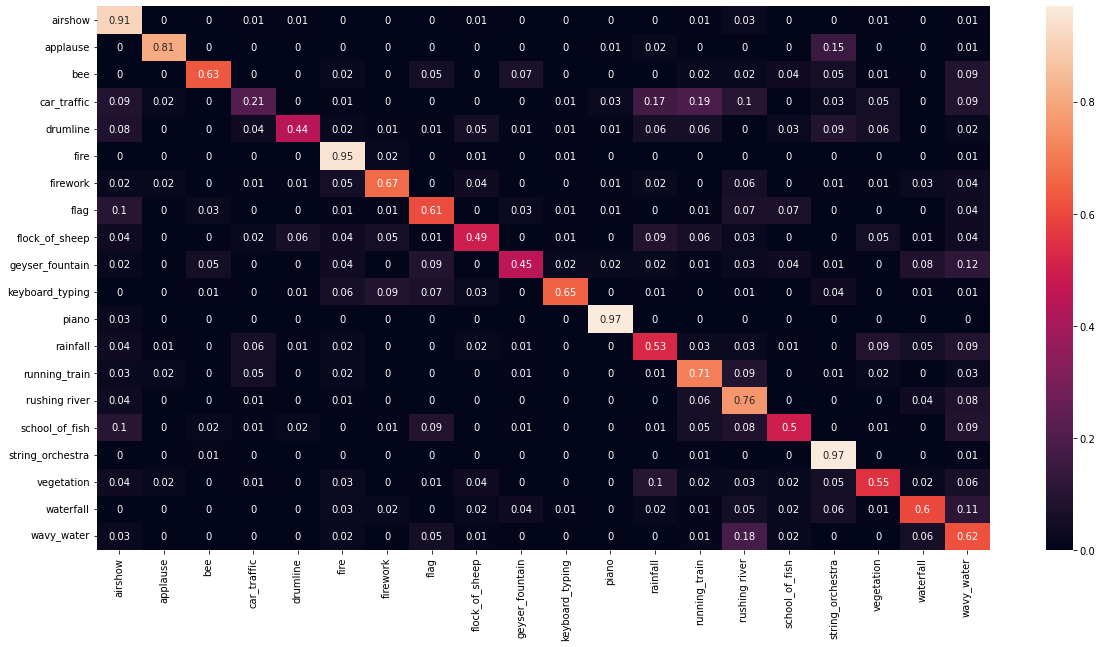

In [24]:
df_cm = pd.DataFrame(conf_mat_fused, index = class_names, columns = class_names)
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)

<AxesSubplot:>

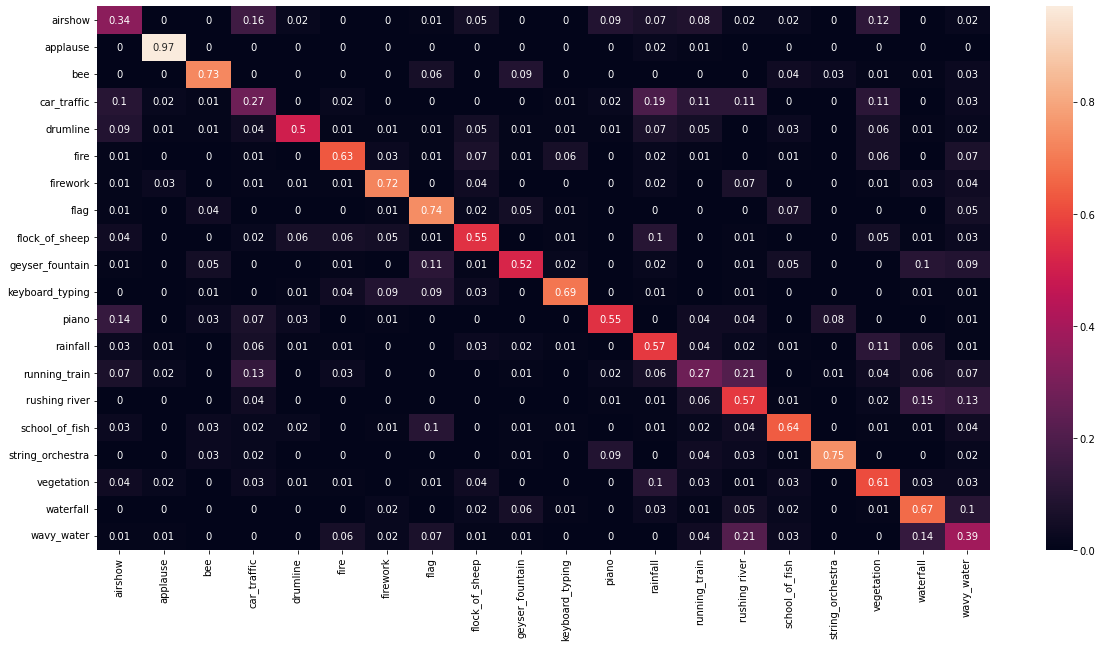

In [26]:
df_cm = pd.DataFrame(conf_mat_aud, index = class_names, columns = class_names)
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)

<AxesSubplot:>

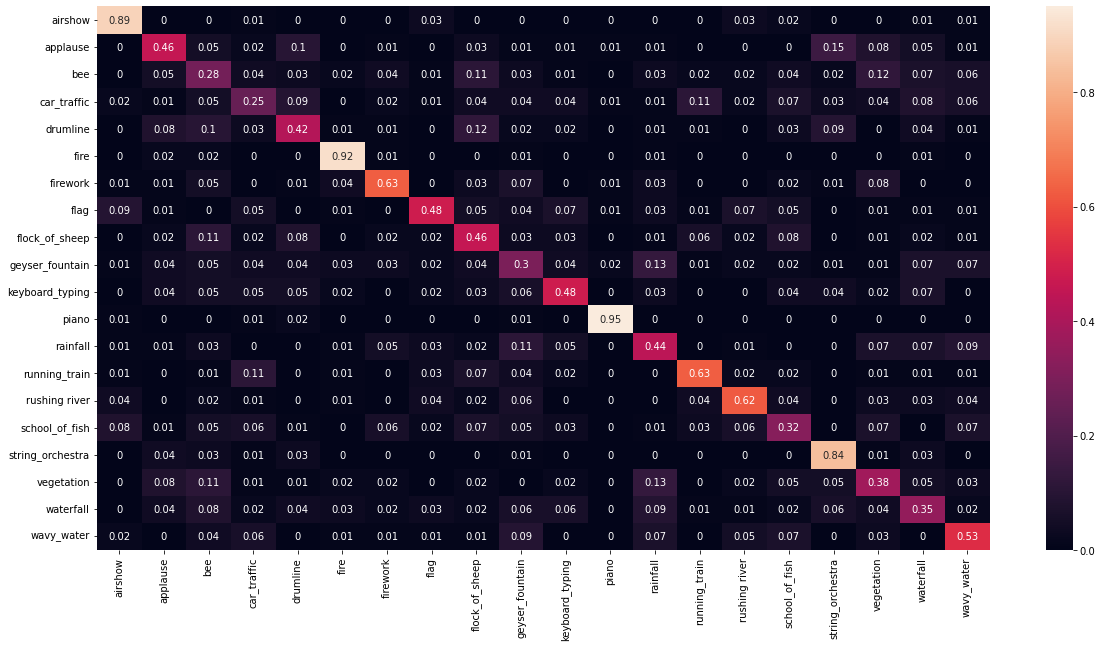

In [27]:
df_cm = pd.DataFrame(conf_mat_vid, index = class_names, columns = class_names)
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)

In [31]:
d = {'audio': aud_diag, 'video': vid_diag}
diag_df = pd.DataFrame(data=d, index = class_names)
diag_df['diff'] = diag_df['audio'] - diag_df['video']
diag_df

,audio,video,diff
airshow,0.34,0.89,-0.55
applause,0.97,0.46,0.51
bee,0.73,0.28,0.45
car_traffic,0.27,0.25,0.02
drumline,0.50,0.42,0.08
fire,0.63,0.92,-0.29
firework,0.72,0.63,0.09
flag,0.74,0.48,0.26
flock_of_sheep,0.55,0.46,0.09
geyser_fountain,0.52,0.30,0.22


In [38]:
diag_df.apply(lambda x: max(x.audio, x.video), axis=1)

airshow             0.89
applause            0.97
bee                 0.73
car_traffic         0.27
drumline            0.50
fire                0.92
firework            0.72
flag                0.74
flock_of_sheep      0.55
geyser_fountain     0.52
keyboard_typing     0.69
piano               0.95
rainfall            0.57
running_train       0.63
rushing river       0.62
school_of_fish      0.64
string_orchestra    0.84
vegetation          0.61
waterfall           0.67
wavy_water          0.53
dtype: float64

In [39]:
diag_df.apply(lambda x: max(x.audio, x.video), axis=1).mean()

0.6779999999999999

In [122]:
pairs = list(zip(vid_NN, aud_NN))

In [125]:
c = 0
for i in range(len(pairs)):
    if (i//100) in pairs[i]:
        c += 1
c / len(pairs)

0.802

In [78]:
sorted_aud_sim[:,-2]

array([  66, 1430,   88, ..., 1855, 1479, 1413])

In [77]:
aud_top2

array([[  17,   66],
       [1431, 1430],
       [ 357,   88],
       ...,
       [1489, 1855],
       [1326, 1479],
       [1470, 1413]])

In [ ]:
import time
import tensorflow as tf
import numpy as np
import sys
import input_data, os
import configure as cfg
import init_SOE_NET as init_net
import SOE_Net_model_full as model


################################################################################################
#""" INITIALIZE SOE-NET PARAMETERS """
################################################################################################
# tf.reset_default_graph()
tf.compat.v1.enable_eager_execution()

orientations = np.array(init_net.initOrientations (cfg.ORIENTATIONS,cfg.SPEEDS,cfg.NUM_DIRECTIONS), dtype=np.float32)
                
#print("[INFO] INIT", orientations,"STANDARD ORIENTATIONS...")
basis = init_net.initSeparableFilters('basis', cfg.FILTER_TAPS, filter_type="G3")

basis_2d = init_net.initSeparableFilters_SO('basis2d', cfg.FILTER_TAPS, filter_type="G2")
#print("[INFO] INIT", basis,"3D SEPARABLE FILTERS...")
#print("[INFO] INIT", basis_2d,"2D SEPARABLE FILTERS...")

biases_soe = init_net.initBiases('bias', 0)
              
#print("[INFO] INIT", biases_soe,"SEPARABLE FILTERS...")

################################################################################################
#""" READ THE INPUT DATA """
################################################################################################

# TEST DATA
tiny_batch_size = 1 # to extract features for one video at a time for this example code purposes
vid_path = "/home/eftekhar/Documents/Databases/AVDT_backup/Frames/clips.txt"
print("[INFO] READING IN TEST DATA FROM :", vid_path)
test_clips, test_start_indices, test_labels = input_data.load_clips_labels(vid_path)
num_test_clips = len(test_clips)
print("[INFO] TOTAL NUMBER OF TESTING VIDEO CLIPS :", num_test_clips)
#raw_input('Press enter to continue ... ')
TEST_ITERS = int(float(num_test_clips)/float(tiny_batch_size))
print("[INFO] NUMPBER OF ITERATIONS TO GO THROUGH TEST SET IS: ", TEST_ITERS)

################################################################################################
#""" PREPARE DATA FOR TENSORFLOW """
################################################################################################
# if cfg.CROP:
#     input_shape   = [tiny_batch_size, cfg.TIME_S, cfg.IMG_S, cfg.IMG_S, 1]
# else:
#     input_shape   = [None, None, None, None, None]
 
# batch_videos_ph = tf.placeholder(tf.float32, shape=input_shape, name="batch_videos")
# print(batch_videos_ph)

################################################################################################   
#""" BUILD THE TENSORFLOW GRAPH """
################################################################################################
# example 4: Extract SOE_Net features
# soenet = model.SOE_Net(batch_videos_ph, basis, orientations, biases_soe)

# # example 2: Extract MSOE features
# msoe = model.get_MSOE(batch_videos_ph, basis, orientations, biases_soe)


# init = tf.global_variables_initializer()
# sess = tf.Session()
# # sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# # initialize the non-trained variables
# sess.run(init)

test_indices = np.arange(num_test_clips)
test_start_idx = 0

SOE_NET_FEAT = []
tic = time.time()
excluded_vid = []
for iter in range(TEST_ITERS):
    """ LOAD VIDEOS ONE BATCH AT A TIME """
    test_batch_clips, test_batch_indices, test_batch_labels, test_stop_idx = input_data.select_batch(test_clips,test_start_indices, test_labels, test_start_idx, test_indices, tiny_batch_size)
    print(test_batch_clips)
    print(test_batch_indices)
    try:
        batch_videos=input_data.load_frames(test_batch_clips,test_batch_indices,crop=False)
        print(batch_videos.shape)
        
    except:
        excluded_vid.append(test_batch_clips[0])
        test_start_idx = test_stop_idx
        continue 
    print("size of clips in batch is : ", np.shape(batch_videos))
    print("stop_idx is : ", test_stop_idx)
    test_start_idx = test_stop_idx
    print("This is iteration number:{}".format(iter))
    #tic = time.time()
#     soenet_feat = sess.run(soenet, feed_dict={batch_videos_ph: batch_videos}) 
    soenet_feat = model.SOE_Net(batch_videos, basis, orientations, biases_soe)
    #print("time to run through one mini-batch is: ", time.time()-tic)
    """ EXAMPLE: SAVE THE RESULTS FOR FURTHER USE (IN ANOTHER APPLICATION FOR EXAMPLE)"""
    for b in range(soenet_feat.shape[0]):
        # TODO: INSTEAD OF APPENDING ACCUMULATE RESULTS OBTAINED BY APPLYING GSP
        SOE_NET_FEAT.append(soenet_feat)
# SOE_NET_FEAT = np.concatenate(SOE_NET_FEAT, axis=0)   
# print(SOE_NET_FEAT.shape)
# # save results to npy file

# feat_path = "./video_features/" + "features_test_3layer_highresolution.npy"
# np.save(feat_path, SOE_NET_FEAT)
# print("time to run through one mini-batch is: ", time.time()-tic)
# print(excluded_vid)
# print('Done')

2022-09-14 16:48:29.802653: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-09-14 16:48:29.827253: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Quadro P6000 major: 6 minor: 1 memoryClockRate(GHz): 1.645
pciBusID: 0000:65:00.0
2022-09-14 16:48:29.827462: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2022-09-14 16:48:29.828808: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2022-09-14 16:48:29.829936: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2022-09-14 16:48:29.830226: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2022-09-14 16:48:29.831828: I tensorflow/stream_executor/platform/defa

[INFO] READING IN TEST DATA FROM : /home/eftekhar/Documents/Databases/AVDT_backup/Frames/clips.txt
[Info] loading lists...
[INFO] TOTAL NUMBER OF TESTING VIDEO CLIPS : 20113
[INFO] NUMPBER OF ITERATIONS TO GO THROUGH TEST SET IS:  20113
['/home/eftekhar/Documents/Databases/AVDT_backup/Frames/flag/flag_115']
[0]
(1, 42, 200, 200, 1)
size of clips in batch is :  (1, 42, 200, 200, 1)
stop_idx is :  1
This is iteration number:0


2022-09-14 16:48:30.594223: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-09-14 16:48:31.476752: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0


In [41]:
import cv2
video_path = '/home/eftekhar/Documents/Databases/AVDT_backup/Frames/flag/flag_1'
filename = cfg.IMAGE_FORMAT.format(0)
img = cv2.imread(os.path.join(video_path, filename))

In [42]:
img = cv2.cvtColor( img, cv2.COLOR_RGB2GRAY )

In [43]:
img_H, img_W = img.shape

In [44]:
import math
scale = math.sqrt((200.0 ** 2) / (img_H * img_W))
new_H, new_W = int(img_H * scale), int(img_W * scale)

In [45]:
img_new = cv2.resize(img, (new_W, new_H), interpolation=cv2.INTER_LINEAR)

In [46]:
img_new.shape

(266, 150)

In [47]:
img.shape

(640, 360)

In [48]:
img_new.shape[0] * img_new.shape[1]

39900

In [6]:
[1,None]

[1, None]